# R notebook to run Scaled Bernoulli Model  synthetic data
Authors: Mudassar Iqbal, Syed Murtuza Baker, Adam Farooq, Magnus Rattray

Date: 29th Jan. 20201

## Functions for plotting/visualisation

In [44]:
# Core Packages needed in different places
library(prabclus,lib.loc='~/R/x86_64-pc-linux-gnu-library/4.0')
library(cluster)
library(ggplot2)
library(mclust)
library(Matrix)

In [74]:
## Calculating Jaccard Distance
getJaccardDist <- function(cdBinary){        
    if(colnames(cdBinary[,2:3])[1] == 'start' & colnames(cdBinary[,2:3])[2] == 'end'){
        SingleCell.Binary <- cdBinary[,4:(dim(cdBinary)[2])]
    }
    else    
    SingleCell.Binary <- cdBinary 
    SingleCell.Binary.Jaccard <- jaccard(as.matrix(SingleCell.Binary))
    return(SingleCell.Binary.Jaccard)
}

In [46]:
## MDS plot function
plotMDS <- function(cdBinary, k, groups=NULL, cellName, ret.val=FALSE, text.label=FALSE, 
                    title="", coordinates=c(1,2)){
    if(missing(ret.val)){
        ret.val = FALSE
    }
    if(text.label==TRUE & missing(cellName)){
        stop("ERROR: Please give cellName")
    }
    
    SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    fit <- cmdscale(as.dist(SingleCell.Binary.Jaccard),eig=TRUE, k=k)

 
    if(is.null(groups)){
        df<-data.frame(x=fit$points[,coordinates[1]],y=fit$points[,coordinates[2]], Cell=colnames(SingleCell.Binary.Jaccard))
        p <- ggplot(df, aes_string(x="x",y ="y"))+ scale_colour_hue(l=40)
    }
    else{
        df<-data.frame(x=fit$points[,coordinates[1]],y=fit$points[,coordinates[2]], Cell=colnames(SingleCell.Binary.Jaccard), Batch=groups)
         p <- ggplot(df, aes_string(x="x",y ="y", color="Batch"))+ 
            scale_colour_hue(l=40) + 
            scale_colour_brewer(palette="Set1") 
    }

    
    p <- p + ggtitle(title) + theme(plot.title = element_text(size = 20, face = "bold"))
    p <- p + geom_point(size = 2)
    p <- p + xlab(paste0("Coordinate ",coordinates[1])) 
    p <- p + ylab(paste0("Coordinate ",coordinates[2]))+
	theme_light(base_size=24) +
        theme(strip.background = element_blank(),
              panel.border     = element_blank(),
              plot.title = element_text(hjust = 0.5))

       
    if(text.label==TRUE)
        p <- p + geom_text(data=df,aes(label=cellName),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45)
    print(p)
    if(ret.val == TRUE)
        return(fit)
}

In [47]:
## Sequencing Depth plot
plotMDSCellDepth <- function(cdBinary, k, cellDepth=NULL, cellName, ret.val=FALSE, text.label=FALSE, 
                    title="", coordinates=c(1,2)){
    if(missing(ret.val)){
        ret.val = FALSE
    }
    if(text.label==TRUE & missing(cellName)){
        stop("ERROR: Please give cellName")
    }    
    SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    fit <- cmdscale(as.dist(SingleCell.Binary.Jaccard),eig=TRUE, k=k)

    if(is.null(cellDepth)){
        df<-data.frame(x=fit$points[,coordinates[1]],y=fit$points[,coordinates[2]], Cell=colnames(SingleCell.Binary.Jaccard))
        p <- ggplot(df, aes_string(x="x",y ="y"))
    }
    else{
        df<-data.frame(x=fit$points[,coordinates[1]],y=fit$points[,coordinates[2]], Cell=colnames(SingleCell.Binary.Jaccard), cellDepth=cellDepth)
         p <- ggplot(df, aes_string(x="x",y ="y", color="cellDepth")) + 
  scale_colour_gradientn(colours = c("blue", "yellow2", "red"))
    }
    
    p <- p + ggtitle(title) + theme(plot.title = element_text(size = 20, face = "bold"))
    p <- p + geom_point(size = 2)
    p <- p + xlab(paste0("Coordinate ",coordinates[1])) 
    p <- p + ylab(paste0("Coordinate ",coordinates[2]))+
	theme_light(base_size=24) +
        theme(strip.background = element_blank(),
              panel.border     = element_blank(),
              plot.title = element_text(hjust = 0.5))
    
    if(text.label==TRUE)
        p <- p + geom_text(data=df,aes(label=cellName),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45)

    print(p)
}

In [48]:
## MDS plot for clusters
plotMDSClust <- function(cdBinary, k, Clusters=NULL, cellName, ret.val=FALSE, text.label=FALSE, 
                    title=""){
    if(missing(k)){
        stop("ERROR: Number of Clusters \"k\" is missing")
    }
    if(missing(ret.val)){
        ret.val = FALSE
    }
    if(text.label==TRUE & missing(cellName)){
        stop("ERROR: Please give cellName")
    }    
    SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    fit <- cmdscale(as.dist(SingleCell.Binary.Jaccard),eig=TRUE, k=k)
 
    if(is.null(Clusters)){
        df<-data.frame(x=fit$points[,1],y=fit$points[,2], Cell=colnames(SingleCell.Binary.Jaccard))
        p <- ggplot(df, aes_string(x="x",y ="y"))+ scale_colour_hue(l=40)
    }
    else{
        df<-data.frame(x=fit$points[,1],y=fit$points[,2], Cell=colnames(SingleCell.Binary.Jaccard), Clusters=Clusters)
        p <- ggplot(df, aes_string(x="x",y ="y", color="Clusters"))+ scale_colour_hue(l=40)
    }
  
    p <- p + ggtitle(title) + theme(plot.title = element_text(size = 20, face = "bold"))
    p <- p + geom_point(size = 2)
    p <- p + xlab("Coordinate 1") 
    p <- p + ylab("Coordinate 2")+
	theme_light(base_size=24) +
        theme(strip.background = element_blank(),
              panel.border     = element_blank(),
              plot.title = element_text(hjust = 0.5))

    if(length(levels(Clusters)) < 12)
        p <- p + scale_colour_brewer(palette="Set1")        
    if(text.label==TRUE)
        p <- p + geom_text(data=df,aes(label=cellName),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45)

    print(p)
}


In [49]:
# multiplot function
multiplot <- function(..., plotList=NULL, File, cols=1, layout=NULL) {
  # Adopted from Cookbook for R
  library(grid)
  plots <- c(list(...), plotList)
  numPlots = length(plots)
  if (is.null(layout)) {
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }
 if (numPlots==1) {
    print(plots[[1]])

  } else {
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))
    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

# Sub-routines for scaled Bernoulli method

In [51]:
## Scaled Bernoulli EM (E-step calculation)
compute_z <- function(max_z_idx,lambda_i_k, x,x_sel){   
  # max_z_idx  - cluster labels
  # lambda_i_k - parameters for mixtures (clusters)
  # x - data matrix (rows = cells, columns = peaks) 
  # x_sel - index of selecrted peaks through feature selection
  weights <- rep(0,K)
  for (k in 1:K){
    weights[k] <- sum(max_z_idx==k)/N      
  }  
	lambda_i_k[lambda_i_k<EPS] = EPS  # EPS is small value (globally defined)
	z_temp <- matrix( data = 0, nrow = N, ncol = K, byrow = T )
	for(i in 1:N){
	  for(j in 1:K){
	    z_temp[i,j] <- (log(weights[j]) +     
	                   sum(x[i,x_sel]*log(lambda_i_k[j,1:length(x_sel)]*alpha[i]+EPS) + 
	                   (1-x[i,x_sel])*log(1-lambda_i_k[j,1:length(x_sel)]*alpha[i]+EPS)))
	  }
    }
return(z_temp)
}

In [52]:
## Calculate Y_i(gain in likelihood---Used for feature selection)
calc_Y_i <- function(max_z_idx,lambda_i_k,lambda_i_0){   # calculating Y_i for individual peaks, using hard EM version for z update (E-step)
  # max_z_idx  - cluster labels
  # lambda_i_k - parameters for mixtures (clusters)
  # lambda_i_0  - parameters when there is only one cluster in the data 
  #First checking for very small values
  lambda_i_k[lambda_i_k<EPS] = EPS  
  
  # calc for Y-i for each peak
  Y <- matrix(0,nrow=D,1) 
  for (i in 1:D){
      Y[i,1] <- sum( x[,i]*(log(alpha*lambda_i_k[max_z_idx,i]+EPS)-log(alpha*lambda_i_0[i]+EPS) )  + (1-x[,i])*(log(1-alpha*lambda_i_k[max_z_idx,i]+EPS) - log(1 - alpha*lambda_i_0[i]+EPS)) )
  }
return(Y) # return full Y 
}

In [53]:
## Calculate deltaY_i(gain in likelihood) -- used for cluster splitting!!! 
calc_deltaY<- function(j,lambda_i_k){   # calculating deltaY for individual peaks for cluster j
  # lambda_i_k - parameters for mixtures (clusters)
  # j - given clusters  
    
  #First checking for very small values
  lambda_i_k[lambda_i_k<EPS1] = EPS1  
  # calc for Y-i for each peak
  deltaY <- matrix(0,nrow=length(x_sel),1) 
  for (i in 1:length(x_sel)){
      mu_split_Y_i <- matrix(0,nrow=1,ncol=2) # 2 columns means one for 0 and other for 1 
      region <- x_sel[i]    
      # Calculating (new M step) mu_ij (for x[i]==0 and x[i]==1)
      mu_split_Y_i[1,1] <- 0.01
      mu_split_Y_i[1,2] <- 0.99
      
      # Derivation where we simplyfy the deltaY equation first, assimung mu_0 = 0 and mu_1 = 1 for possible split
      deltaY[i,1]  <- - sum(log(1-alpha[x[,region]==0]*lambda_i_k[j,i])) + sum(log(alpha[x[,region]==1]) - log(alpha[x[,region]==1]*lambda_i_k[j,i]))        
  }
return(deltaY)
}

In [54]:
## Calculating log likelihood for single `i`, 'k' 
log_likelihood_single_i_k <- function(lambda_i_k_opt, weights, i, k){  
  # i - peak
  # k - cluster
  #lambda_i_k_opt - parameter (labmda for cluster k and peak i) to be optimized.
  z_final <-  (sum( x[max_z_idx==k,x_sel[i]]*log(alpha[max_z_idx==k]*lambda_i_k_opt+ EPS)   +  (1-x[max_z_idx==k,x_sel[i]])*log(1-alpha[max_z_idx==k]*lambda_i_k_opt+ EPS)) )  
return(-z_final)
}

In [55]:
# Sub-routine for M-step, optimising all parameters
calculateMu <- function(x_sel,pi_temp){ 
  #x_sel - selected peak indexes (through feature selection)
  # pi_temp - weights for each cluster (pi)  
  mu_temp <- matrix(0, nrow = K, ncol = length(x_sel))
  obj_temp <- 0
  sm1 <- 0
  sm2 <- 0
  sm3 <- 0
  for(i in 1:length(x_sel)){
    for(k in 1:K){
      
      # === M-update (using approx. LK) ======
      sm1 <- sum(EPS1+ x[max_z_idx==k,x_sel[i]])
      sm2 <- sum(EPS1+ alpha[max_z_idx==k]*(1-x[max_z_idx==k,x_sel[i]]))
      sm3 <-  sum(EPS1+ alpha[max_z_idx==k]*x[max_z_idx==k,x_sel[i]])         
      
      mu_k_i<-(sm1/(sm2+sm3)) 

      if(mu_k_i>=1) {mu_k_i <- 0.99}
      if(mu_k_i<=0) {mu_k_i <- 0.01}
      mu_temp[k,i] <- mu_k_i
 
      temp <- log_likelihood_single_i_k(lambda_i_k_opt=mu_k_i, weights=pi_temp, i=i, k=k) 
      obj_temp <- obj_temp + temp    
    }
  }
 return(list(mu_temp, obj_temp)) # output - optimised parameters, and objective function  
}

In [56]:
### M-step main routine
MaximizationStep_optim <- function(x_sel){ # x_sel - currently selected subset of x (based on Y - likelihood gain)
  pi_temp <- rep(0,K)
  for (k in 1:K){
    pi_temp[k] <- sum(max_z_idx==k)/N       
  }
  resTmp <- calculateMu(x_sel,pi_temp)
  lambda_i_k_temp = resTmp[[1]]
  objective_temp = resTmp[[2]]
  return(list(pi_temp, lambda_i_k_temp, objective_temp))
}

In [70]:
## = ====== Readiong data and processing Initialising =======================

# Reading 1K synthetic data (as CSV with peaks in the rows and cells in the columns)
cd <- read.csv('./../Data/Synthetic_data_1K.csv', header = TRUE, row.names = 1)
cd <- cd[1:dim(cd)[1], 1:dim(cd)[2]]
x <- as.matrix(t(cd))

x[x>0] <- 1 # Just to make sure!

# === Filtering  =====
x <- x[rowSums(x) !=0,colSums(x) !=0] # deleting empty/zero rows and columns
x <- x[ ,colSums(x)>=round(0.01*nrow(x)) ] #Keeping peaks ON in atleast 1% cells 
#x <- x[rowSums(x)>=round(0.001*ncol(x)), ] #Keeping cells with atleast 1% ON peaks
x <- x[rowSums(x) !=0,colSums(x) !=0]

#  x <- x[,colSums(x)<=round(0.8*nrow(x)) ] # might want to delete extremly abudant peaks 


# ==== Initialisation ====
D <- ncol(x) # number of peaks
N <- nrow(x) #number of cells
alpha <- rowSums(x)/max(rowSums(x))  # Initalizing alpha (sequencing depth - scaling factor)
  # Calculating labda_i_0 (for each peak, no clustering structure among cells)
lambda_i_0_save <- matrix(0,nrow = 1,ncol = D) # Calculating labda_i_0, no clustering structure among cells
lambda_i_0_save[1,] <- colSums(x)/N 

x_save <-x # just saving a copy

In [71]:
dim(x)

[1]  1000 17255

In [92]:
#### =========================== Main function =============================
library(mclust)
old <- Sys.time()
print(old)  # printing starting time

# Some global stuff
x <- x_save

EPS  <- 0.000001 # small value, gloablly defined, for dealing with underflow
delta <-0.001 # Used in EM convergence stopping crit4eria
Kmax <- 10 # max non. of clusters

lambda_i_0 <- matrix(0,nrow = 1, ncol = sum(colSums(x)<round(1*nrow(x_save)))) 
lambda_i_0[1,] <- lambda_i_0_save[1,colSums(x)<round(1*nrow(x_save))]

max_z_idx <- matrix(1,nrow=N,1) # cluster labels, global variable, initialzed with 1 (every cell belong to cluster 1 to start with)
pi <- 1 # cluster proportions
lambda_i_k <- lambda_i_0 # Model parameters
max_z_idx_copy <- max_z_idx # used for final stopping criteria 


K <- 1 # starting number of clusters
K_current <- 1
x_sel <- 1:dim(x)[2] # Index of selected peaks, all of them here to start with 


# == Some flags == 
final_exit <- 0
flag_Y <- 0


# New main loop
for(i in 1:10){ # Algorithm's outer iterations
    
   split <- 0 
   for(j in 1:K_current){ # going through current number of clusters--split each one of them

     if(sum(max_z_idx==j)>= round(0.01*N)){
      #====  Cluster splitting (and EM within) ====
      deltaY_j <- calc_deltaY(j,lambda_i_k) 
      # decide top region indexes
      x_top <- order(deltaY_j[1:length(x_sel)],decreasing = TRUE)[deltaY_j>quantile(deltaY_j)[4]]
     
      # upto 10 attemps to split cluster j
      counter <- 1 
      tmp = matrix(0,nrow =10, ncol = 2)  
      while(counter <= 10){ 
      tmp[counter,1] <- sample(1:length(x_top),1) 
      idx <- tmp[counter,1]
      tmp[counter,2] <- length(max_z_idx[max_z_idx==j & x[,x_sel[x_top[idx]]]==1])
      if(deltaY_j[x_top[idx]]<=0 | tmp[counter,2] < round(0.01*N)){ # or 10, 20 cells
          tmp[counter,2] <- 0
      #break
      }
     counter <-counter +1   
     }
    # optimal split   
    m <- which.max(tmp[,2])
    idx <- tmp[m,1]    
    if(tmp[m,2]>0){ 
        split <- 1
        max_z_idx[max_z_idx==j & x[,x_sel[x_top[idx]]]==1] = K + 1
        lambda_i_k <- rbind(lambda_i_k,colSums(x[max_z_idx==(K + 1),x_sel])/sum(max_z_idx==(K + 1))) 
        K = K + 1
     } 
    } # if
   }# for(j in 1:K_current)
   
    
 # ========== After all the splitting done, run EM to convergenceso ========
 if(split == 1){
    converged <- 0
    resEM <- MaximizationStep_optim(x_sel) # M-step, First iter
    objective_tmp <- resEM[[3]]
       
    lambda_i_k[1:K,1:length(x_sel)] <- resEM[[2]]
    lambda_i_k_old <- lambda_i_k
    iter <- 0
    while(converged == 0){
         z <- compute_z(max_z_idx ,lambda_i_k, x, x_sel) # E-setp
         for (l in 1:N){
             max_z_idx[l] <- which.max(z[l,])
         }
         resEM <- MaximizationStep_optim(x_sel) # K is global variable which is used in many functions
         lambda_i_k[1:K,1:length(x_sel)] <- resEM[[2]]
         lambda_i_k_old <- lambda_i_k
         tmp <- abs(resEM[[3]] - objective_tmp)
         if(tmp <= delta*abs(objective_tmp) | iter>=20) { 
            converged <- 1
         }
         iter <- iter + 1
         objective_tmp <- resEM[[3]]
         
    }# while
  }# if split
    
    
    
    # ======== Calculate variable selection (only once after there are at least two clusters)   ======
    if(K >= 2 & flag_Y==0){
      flag_Y <- 1 # just to make sure it is only done once
      Y <- calc_Y_i(max_z_idx,lambda_i_k,lambda_i_0) 
      x_sel <- order(Y,decreasing = TRUE)[Y>quantile(Y)[4]]   
      lambda_i_k <-  lambda_i_k[,x_sel]   
    }
    
 # printing   
 BC <- 0.5*length(x_sel)*log(N) # BIC penality clusterwise.
 cat("After Splitting - ",i,K,objective_tmp,"\n") # current iter, no. of clusters, and objective value
 K_current <- K
 for(k in 1:K){print(sum(max_z_idx==k))} 
    
#====  Merging operations (only for more than two clusters!) ==========
     
 # merging iterations 
 if(K_current>2){

     m <- 1
     while(m<=(K-1)){
         max_z_idx_old <- max_z_idx
         lambda_i_k_old <- lambda_i_k
         y <- 1
         # Hellinger similarity among current clusters
         cluster_sim <- matrix(10000,nrow = (K-m),ncol = 2)
         for(l in (m+1):K){     
             cluster_sim[y,1] <- l
             cluster_sim[y,2] <- sqrt(0.5)*sqrt(sum((sqrt(lambda_i_k[m,])- sqrt(lambda_i_k[l,]))^2)) # using Hellinger             
             y <- y + 1
         }# l-for loop
      cluster_sim <- cluster_sim[order(cluster_sim[,2]),]      
      idx1 <- m
      if(length(cluster_sim)>2){idx2 <-  cluster_sim[1,1]} # with only one row, it becomes a vector! need better soliution
      else{idx2 <- cluster_sim[1]}
         
      cat("Attempting to merge ", idx1,sum(max_z_idx==idx1), "and ",idx2,sum(max_z_idx==idx2) ) 
          
      max_z_idx[max_z_idx==idx2] <- idx1 # moving to smaller index cluster!
      if(idx2 < K) {max_z_idx[max_z_idx > idx2] <- max_z_idx[max_z_idx > idx2] - 1}
      
      K <- K-1 # reducing no of clusters
      
      # updating params accordingly   
      if(K==1){lambda_i_k <- matrix(lambda_i_k,nrow = 1, ncol = length(x_sel))}
      else{
          lambda_i_k[idx1,] <- (lambda_i_k[idx1,] + lambda_i_k[idx2,])/2  #avg params
          lambda_i_k <- lambda_i_k[-idx2,]
      }
      
      pi_temp <- rep(0,K)
      for (k in 1:K){
        pi_temp[k] <- sum(max_z_idx==k)/N
      }
      tmp_obj <- 0
      for(n in 1:length(x_sel)){
         for(k in 1:K){
            result <- log_likelihood_single_i_k(weights = 
                                                  pi_temp,i=n,k=k,lambda_i_k_opt=lambda_i_k[k,n])
            tmp_obj <- tmp_obj + (-1.0*result)
        }
      }
      deletion_loss <- -1.0*objective_tmp - tmp_obj
      cat("\t deletionLoss = ",deletion_loss, "BC=",BC, "\n")

      if(deletion_loss >= BC){ # we only merge if deletion loss is less than BC
        # back to normal
        max_z_idx <- max_z_idx_old
        K = K + 1 
        lambda_i_k <- lambda_i_k_old
      }
     else { 
        converged <- 0      
        resEM <- MaximizationStep_optim(x_sel) # M-step, First iter
        lambda_i_k[1:K,1:length(x_sel)] <- resEM[[2]]
        lambda_i_k_old <- lambda_i_k
        iter <- 0
        while(converged == 0){
            z <- compute_z(max_z_idx ,lambda_i_k, x, x_sel) # E-setp
            for (l in 1:N){
                 max_z_idx[l] <- which.max(z[l,])
            }
            resEM <- MaximizationStep_optim(x_sel) # K is global variable which is used in many functions
            lambda_i_k[1:K,1:length(x_sel)] <- as.matrix(resEM[[2]])
            tmp <- abs(resEM[[3]] - objective_tmp)
            if(tmp <= delta*abs(objective_tmp) | iter>=20) { 
              converged <- 1
            }
            iter <- iter + 1
            objective_tmp <- resEM[[3]]
        }#while  
     }
          
     m <- m + 1
     }# m- loop
     

     K_current <- K
 

 # printing  
 cat("After Merging - ",i,K,objective_tmp,"\n") # current iter, no. of clusters, and objective value  
 for(k in 1:K){print(sum(max_z_idx==k))}   

 }#if(K_current>=2)  
  
  # ==== Final stopping criteria ======
  if(i<2) {
    vvmax_z_idx_copy <- max_z_idx     
  }
  else if(adjustedRandIndex(max_z_idx,max_z_idx_copy)>=0.8) {
      cat('ARI = ',adjustedRandIndex(max_z_idx,max_z_idx),'\n')
      if(final_exit ==1){break}
      else{ 
          final_exit <- 1
          max_z_idx_copy <- max_z_idx
      }  
   }
   else{
    cat('ARI = ',adjustedRandIndex(max_z_idx,max_z_idx_copy),'\n')
    max_z_idx_copy <- max_z_idx
    final_exit <- 0
  }

    
}#i outermost 

new <- Sys.time() - old
print(new) # printing time

# writing clustering lables to file
write.csv(max_z_idx, './Cluster_labels.csv')  


[1] "2021-01-28 17:27:05 GMT"
After Splitting -  1 2 4174663 
[1] 457
[1] 543
After Splitting -  2 4 1223383 
[1] 267
[1] 239
[1] 188
[1] 306
Attempting to merge  1 267 and  3 188	 deletionLoss =  2283.733 BC= 14900.03 
Attempting to merge  2 237 and  3 307	 deletionLoss =  25398.85 BC= 14900.03 
After Merging -  2 3 1225390 
[1] 456
[1] 237
[1] 307
ARI =  0 
After Splitting -  3 6 1219829 
[1] 321
[1] 159
[1] 243
[1] 135
[1] 78
[1] 64
Attempting to merge  1 321 and  4 135	 deletionLoss =  1975.704 BC= 14900.03 
Attempting to merge  2 159 and  4 78	 deletionLoss =  2036.401 BC= 14900.03 
Attempting to merge  3 241 and  4 64	 deletionLoss =  1857.402 BC= 14900.03 
After Merging -  3 3 1225391 
[1] 458
[1] 237
[1] 305
ARI =  1 
After Splitting -  4 6 1219807 
[1] 340
[1] 184
[1] 198
[1] 116
[1] 54
[1] 108
Attempting to merge  1 340 and  4 116	 deletionLoss =  2045.105 BC= 14900.03 
Attempting to merge  2 183 and  4 54	 deletionLoss =  2035.607 BC= 14900.03 
Attempting to merge  3 198 and

In [18]:
print(table(max_z_idx))

max_z_idx
  1   2   3 
455 238 307 
[1] 4314


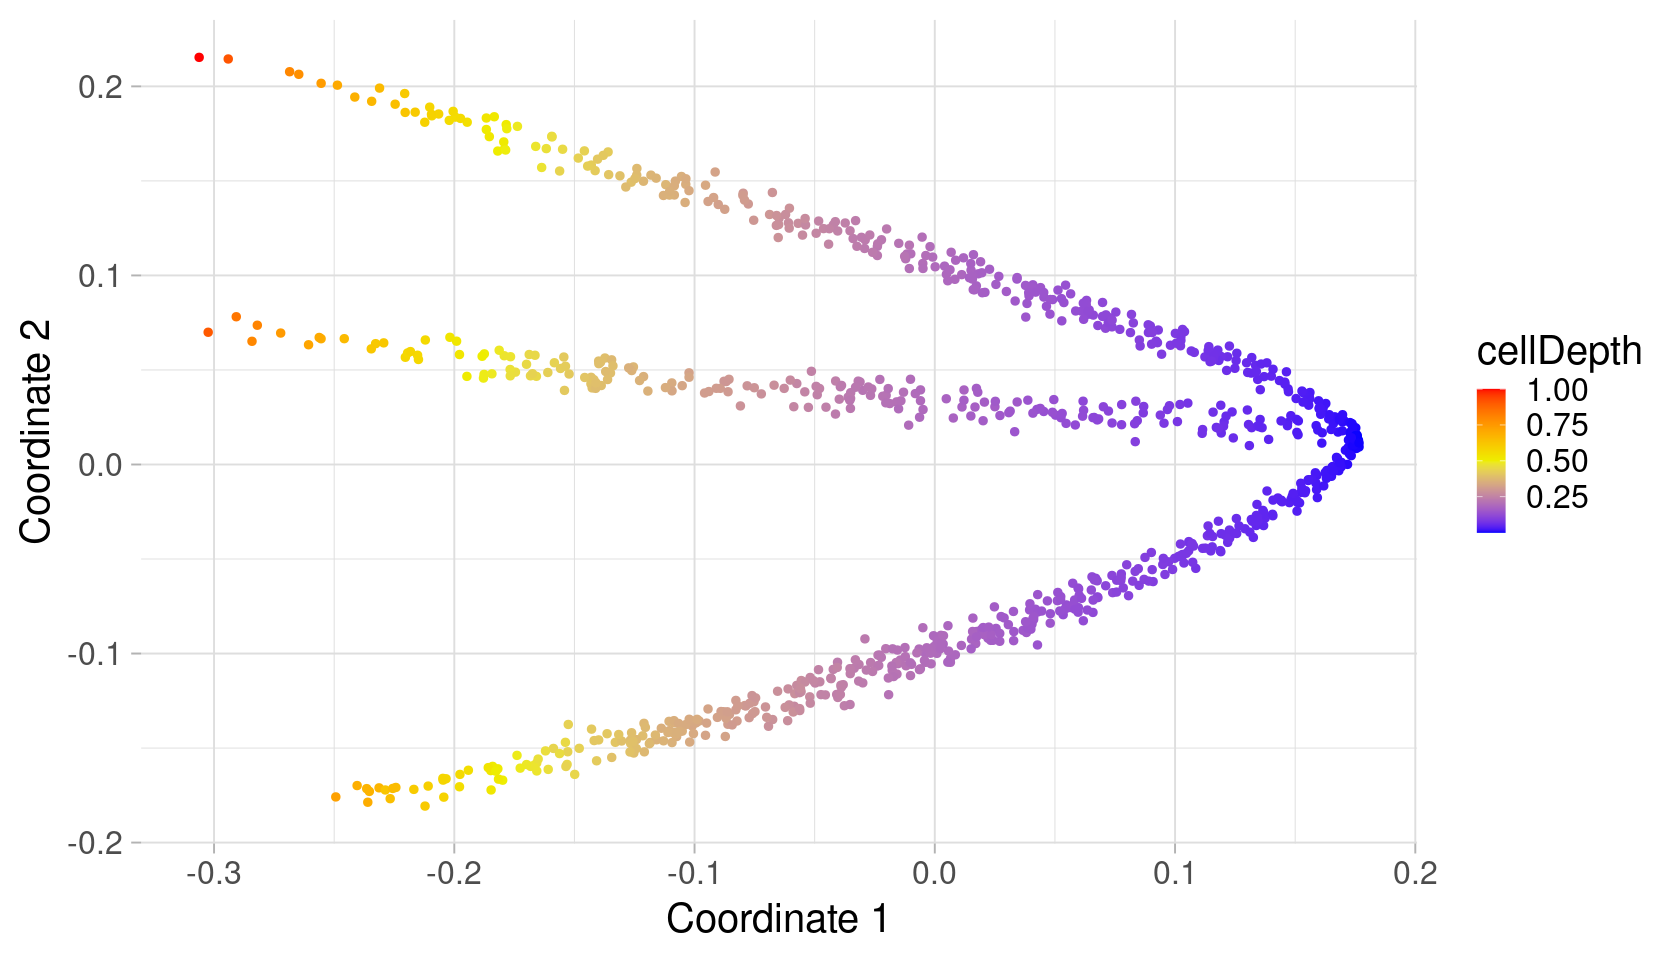

In [75]:
# Read depeth displayed on MDS
options(repr.plot.width=14, repr.plot.height=8)
dp <- colSums(t(x),dims=1)/max(colSums(t(x),dims=1))
plotMDSCellDepth(t(x), 4, cellDepth = dp, cellName = NULL, title=NULL)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



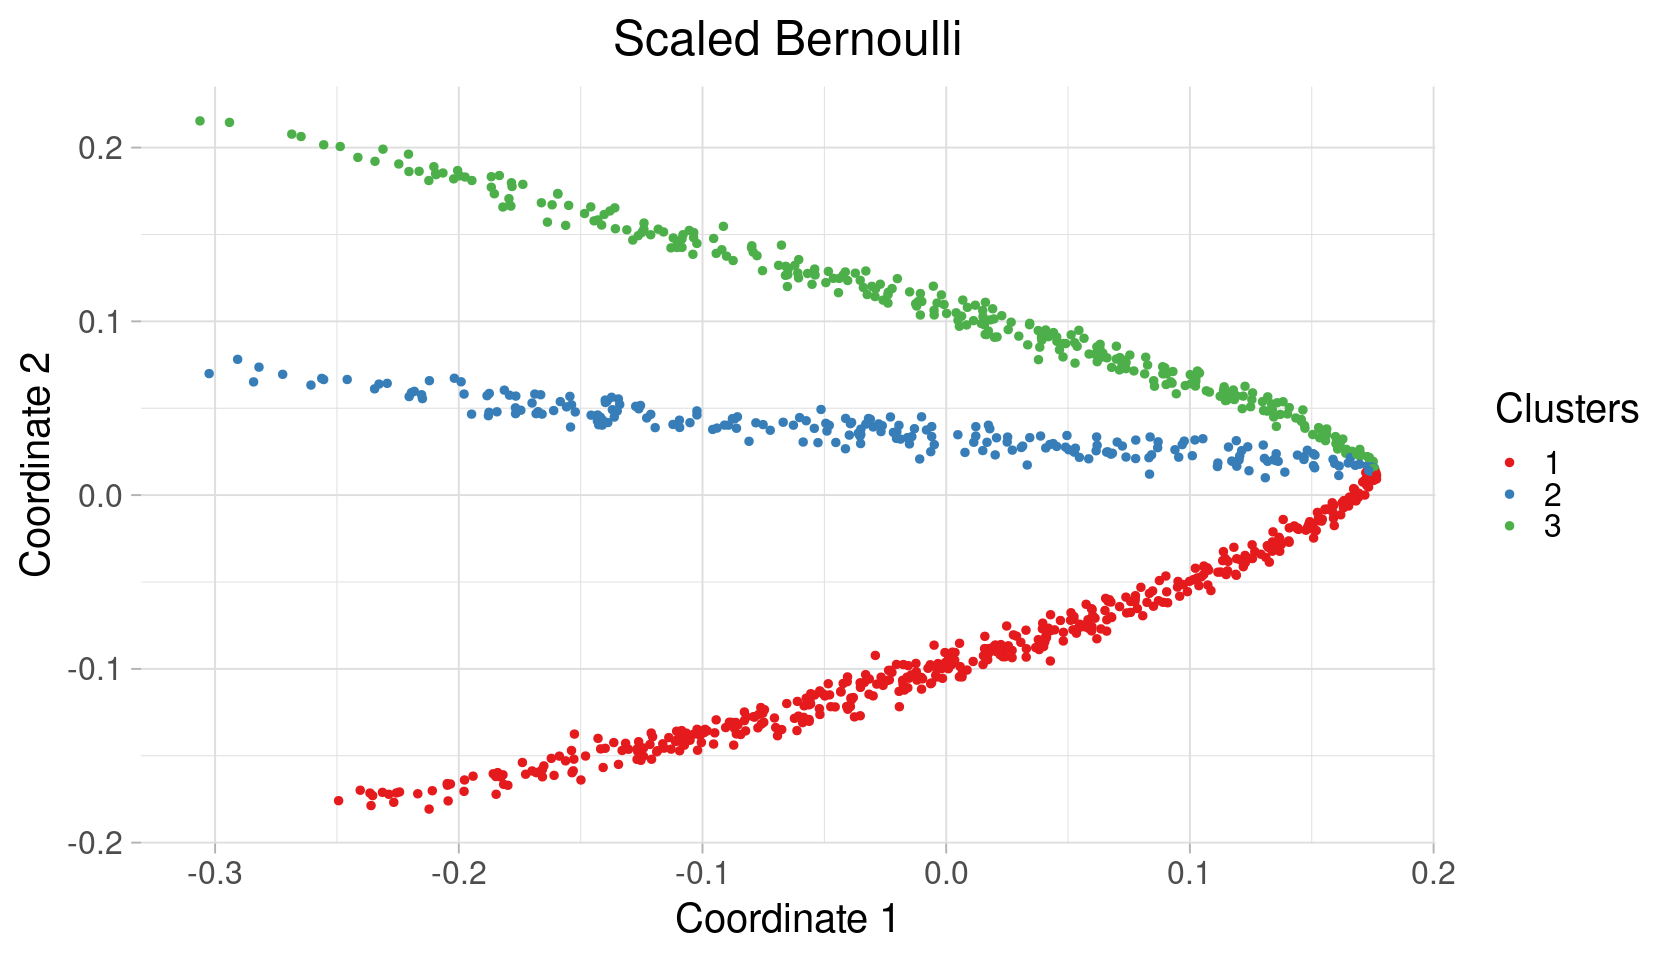

In [77]:
## Plotting of scaled Bernoulli clusters on MDS
library(ggplot2)
options(repr.plot.width=14, repr.plot.height=8)

plotMDSClust(t(x), 4, Clusters=paste0(as.character(as.vector(max_z_idx))), ret.val=TRUE, text.label=FALSE, title="Scaled Bernoulli")

# Signac Clustering 

In [78]:
library(Seurat)
library(Signac)

In [79]:
# Script for creating LSI based clusters (Signac), we can run these code snippets with and without dropping 1st LSI component
x_Seurat <- CreateSeuratObject(
  counts = t(x), # before this x is cellsXpeaks, so transposing it so this script will cluster cells
  #assay = "peaks",
  #meta.data = metadata
)

x_Seurat <- RunTFIDF(x_Seurat)
x_Seurat <- FindTopFeatures(x_Seurat, min.cutoff = 'q0')
x_Seurat <- RunSVD(x_Seurat)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings



In [80]:
x_Seurat <- RunUMAP(object = x_Seurat, reduction = 'lsi', dims = 1:30)
x_Seurat <- FindNeighbors(object = x_Seurat, reduction = 'lsi', dims = 1:30)
x_Seurat <- FindClusters(object = x_Seurat, verbose = FALSE, algorithm = 3)
#DimPlot(object = x_Seurat, label = TRUE) + NoLegend()

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
17:17:29 UMAP embedding parameters a = 0.9922 b = 1.112

17:17:29 Read 1000 rows and found 30 numeric columns

17:17:29 Using Annoy for neighbor search, n_neighbors = 30

17:17:29 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

17:17:30 Writing NN index file to temp file /tmp/1635593.1.parallel.q/RtmpUvwWcA/file3cea1810e8c3

17:17:30 Searching Annoy index using 1 thread, search_k = 3000

17:17:30 Annoy recall = 100%

17:17:31 Commencing smooth kNN distance calibration using 1 thread

17:

In [82]:
# Signac clusters (with first LSI component)
clusters_Seurat_with = x_Seurat@active.ident
length(clusters_Seurat_with)

[1] 1000

In [83]:
# UMPA from Seurat (we will use this for plotting)
umap_Seurat = x_Seurat@reductions$umap
dim(umap_Seurat)

[1] 1000    2

In [85]:
# Now running again for without first LSI reductioin
x_Seurat1 <- CreateSeuratObject(
  counts = t(x), # before this x is cellsXpeaks, so transposing it so this script will cluster cells
  #assay = "peaks",
  #meta.data = metadata
)

x_Seurat1 <- RunTFIDF(x_Seurat1)
x_Seurat1 <- FindTopFeatures(x_Seurat1, min.cutoff = 'q0')
x_Seurat1 <- RunSVD(x_Seurat1)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings



In [86]:
# Without first LSI component
x_Seurat1 <- RunUMAP(object = x_Seurat1, reduction = 'lsi', dims = 2:30)
x_Seurat1 <- FindNeighbors(object = x_Seurat1, reduction = 'lsi', dims = 2:30)
x_Seurat1 <- FindClusters(object = x_Seurat1, verbose = FALSE, algorithm = 3)

17:20:12 UMAP embedding parameters a = 0.9922 b = 1.112

17:20:12 Read 1000 rows and found 29 numeric columns

17:20:12 Using Annoy for neighbor search, n_neighbors = 30

17:20:12 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

17:20:12 Writing NN index file to temp file /tmp/1635593.1.parallel.q/RtmpUvwWcA/file3cea6dd771a2

17:20:12 Searching Annoy index using 1 thread, search_k = 3000

17:20:13 Annoy recall = 100%

17:20:14 Commencing smooth kNN distance calibration using 1 thread

17:20:15 Initializing from normalized Laplacian + noise

17:20:15 Commencing optimization for 500 epochs, with 32350 positive edges

17:20:19 Optimization finished

Computing nearest neighbor graph

Computing SNN



In [87]:
# Signac clusters (without first LSI component)
clusters_Seurat_without = x_Seurat1@active.ident
length(clusters_Seurat_without)

[1] 1000

# Combined plotting/visualization

In [88]:
# ==== tsNE and umap based plotting ==========
# Here, we have tSNE and umap co-ordinates, and different type of clustering

# 1 - Our Scaled Bernoulli
#clusters_SB <- read.csv('./NewSyntheticData_Adam/ClusterLabels_1K_130121.csv')
#clusters_SB <- clusters_SB[,2]

clusters_SB <- max_z_idx

# 2- FlexMix cluster labels
clusters_FlexMix <- read.csv('./../Data/flexMix_cluster_1k.csv')
clusters_FlexMix <- clusters_FlexMix[,3]

# Then two clustering from seurat/signa (with and without first PC)

tsne_12 <- read.csv('./../Data/tsne_1k.csv')
tsne_12 <- tsne_12[,2:3]


# sequencing depth 
dp <- colSums(t(x),dims=1)/max(colSums(t(x),dims=1)) # no. of 1s normalized 



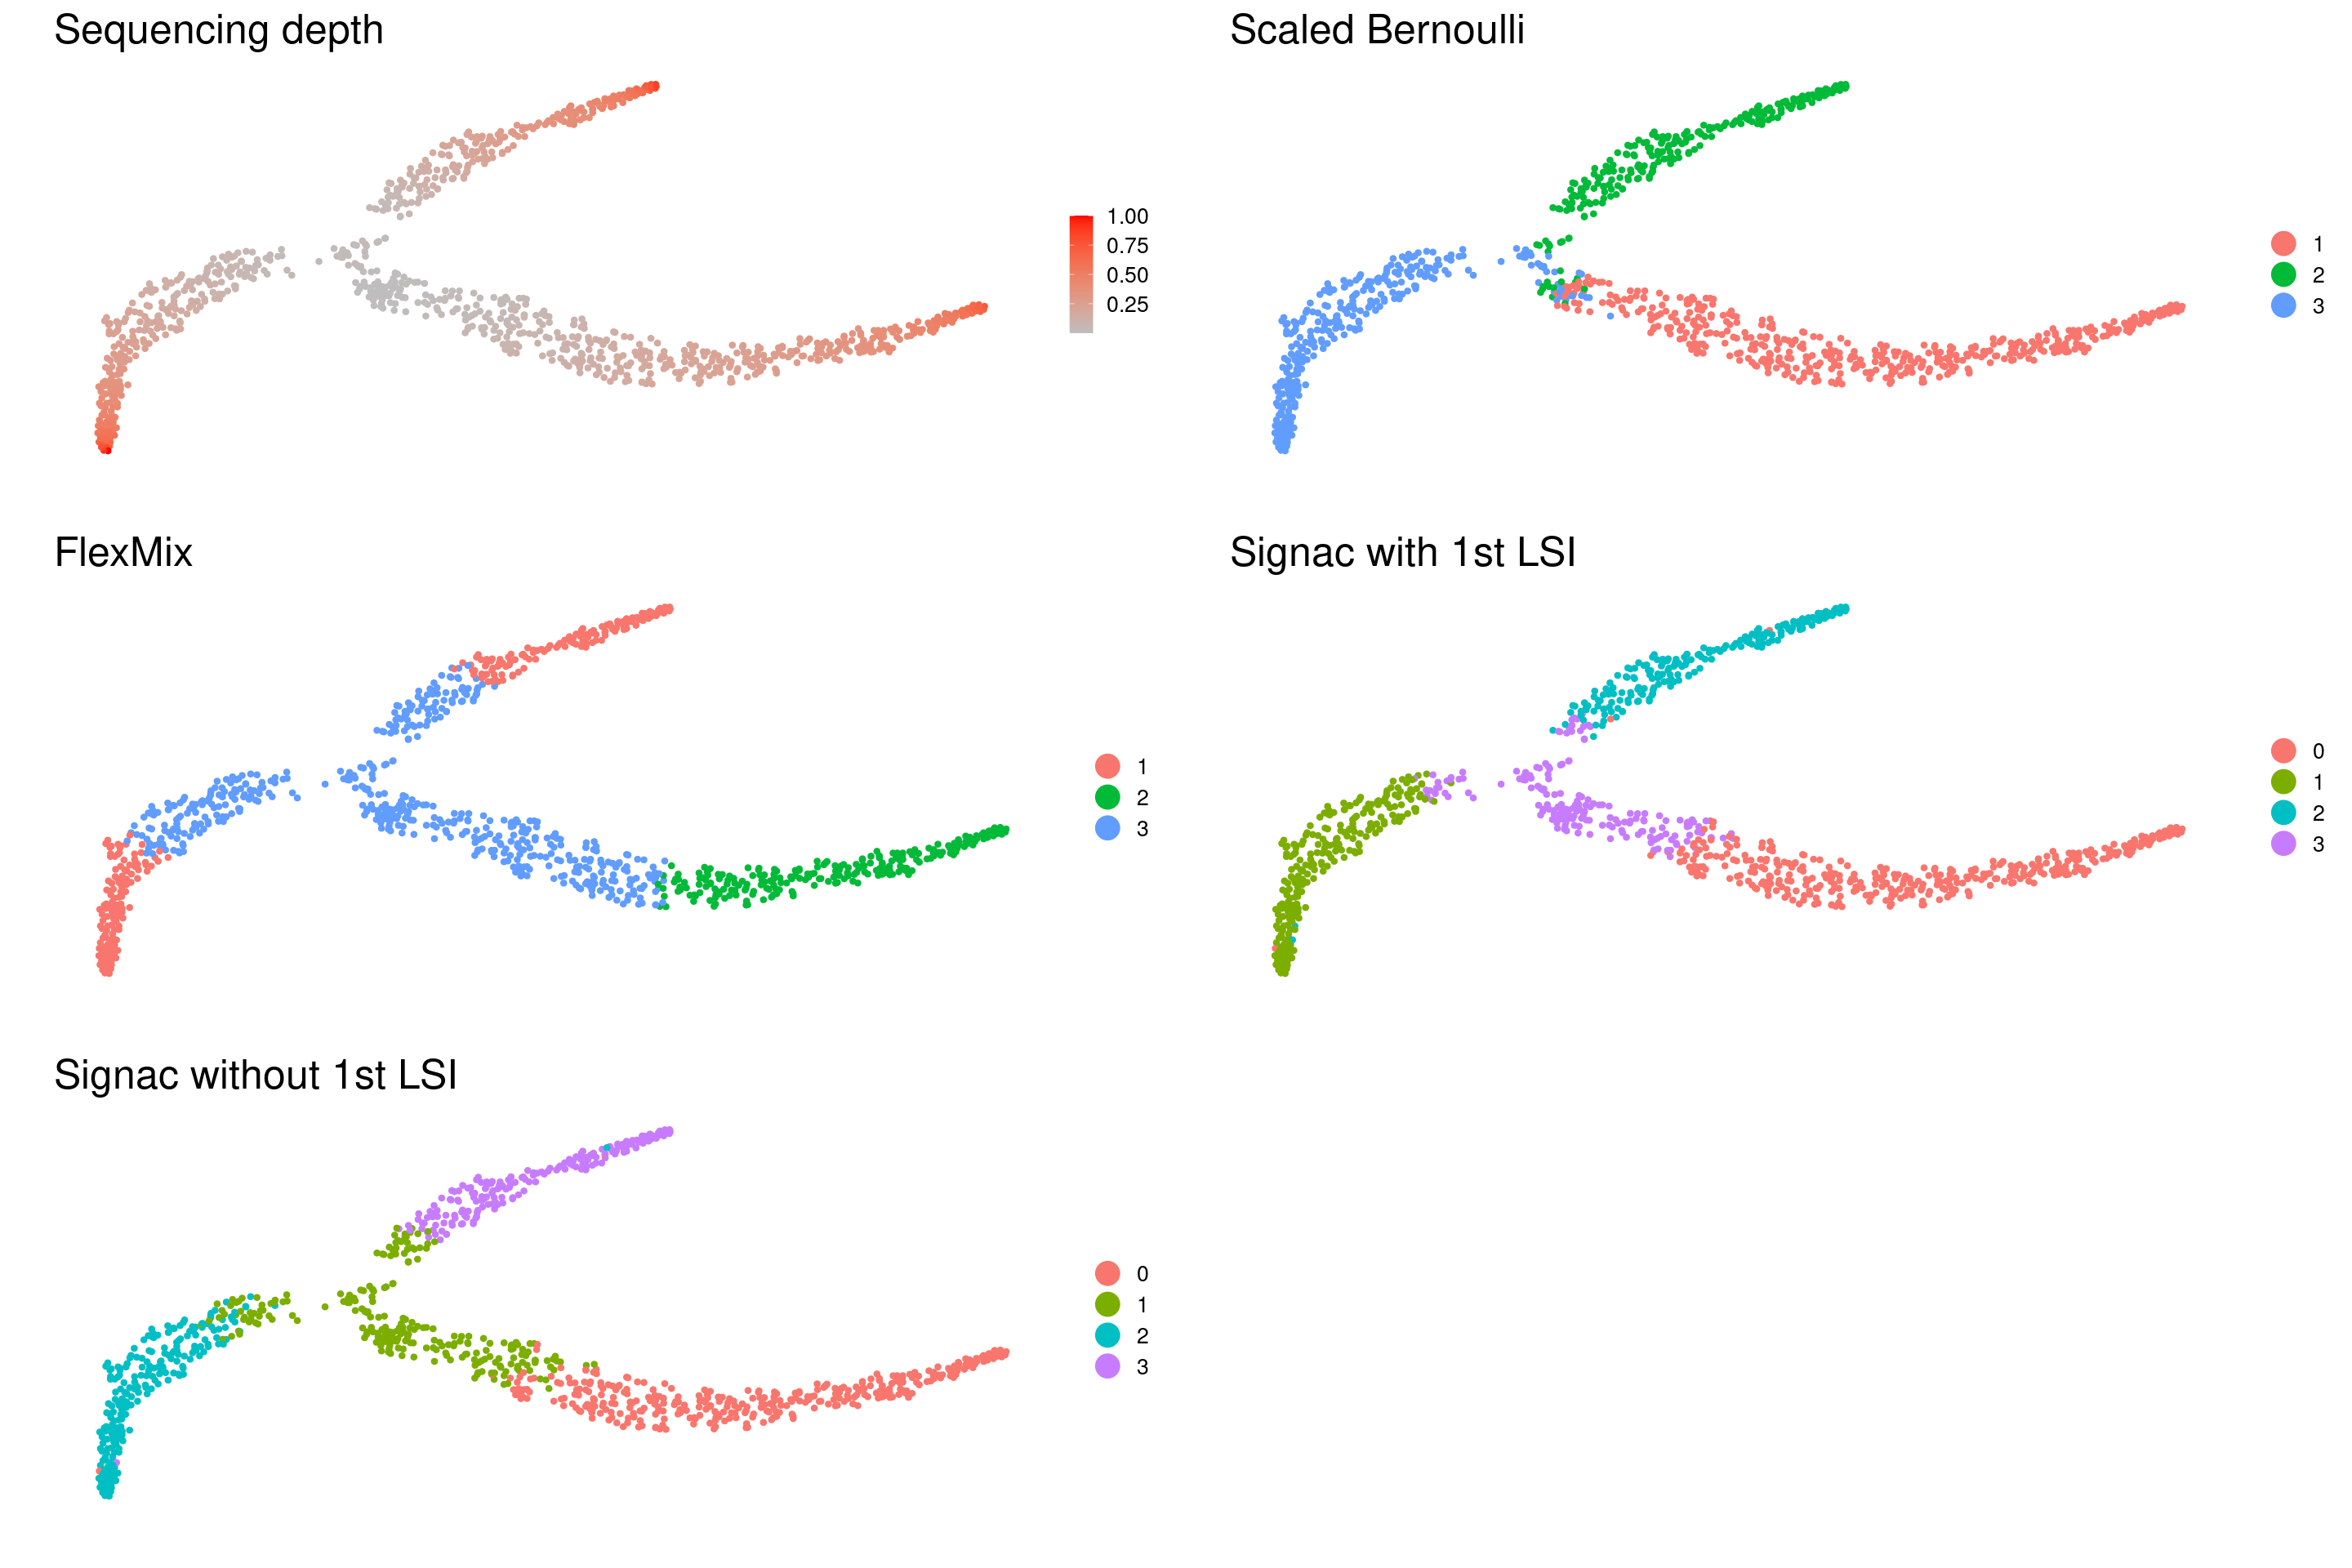

In [89]:
# ============= tsne  ==========================

options(repr.plot.width=24, repr.plot.height=16)

p1 <- ggplot(tsne_12, aes(x=tsne_12[,1], y=tsne_12[,2], color=dp)) +
     geom_point(size=1.75) +
scale_colour_gradient(
  low = "grey",
  high = "red",
  space = "Lab",
  na.value = "grey50",
  guide = "colourbar",
  aesthetics = "colour"
)+
     #guides(colour = guide_legend(override.aes = list(size=2.5))) +
     xlab("") + ylab("") +
     ggtitle("Sequencing depth") +
     theme_classic(base_size=20) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank(),
           plot.title = element_text(size=30)) + 
labs(colour = NULL)#+
#guides(colour = guide_legend(override.aes = list(size=8)))




p2 <- ggplot(tsne_12, aes(x=tsne_12[,1], y=tsne_12[,2], color=as.factor(clusters_SB),text=as.factor(clusters_SB))) +
     geom_point(size=1.75) +
     guides(colour = guide_legend(override.aes = list(size=2.5))) +
     xlab("") + ylab("") +
     ggtitle("Scaled Bernoulli") +
     theme_classic(base_size=20) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
          plot.title = element_text(size=30)) + 
labs(colour = NULL)+
guides(colour = guide_legend(override.aes = list(size=8)))



 p3 <- ggplot(tsne_12, aes(x=tsne_12[,1], y=tsne_12[,2], color=as.factor(clusters_FlexMix),text=as.factor(clusters_FlexMix))) +
     geom_point(size=1.75) +
     guides(colour = guide_legend(override.aes = list(size=2.5))) +
     xlab("") + ylab("") +
     ggtitle("FlexMix") +
     theme_classic(base_size=20) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           plot.title = element_text(size=30)) + 
labs(colour = NULL)+
guides(colour = guide_legend(override.aes = list(size=8)))



 p4 <- ggplot(tsne_12, aes(x=tsne_12[,1], y=tsne_12[,2], color=as.factor(clusters_Seurat_with),text=as.factor(clusters_Seurat_with))) +
     geom_point(size=1.75) +
     guides(colour = guide_legend(override.aes = list(size=2.5))) +
     xlab("") + ylab("") +
     ggtitle("Signac with 1st LSI") +
     theme_classic(base_size=20) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           plot.title = element_text(size=30)) + 
labs(colour = NULL)+
guides(colour = guide_legend(override.aes = list(size=8)))



 p5 <- ggplot(tsne_12, aes(x=tsne_12[,1], y=tsne_12[,2], color=as.factor(clusters_Seurat_without),text=as.factor(clusters_Seurat_without))) +
     geom_point(size=1.75) +
     guides(colour = guide_legend(override.aes = list(size=2.5))) +
     xlab("") + ylab("") +
     ggtitle("Signac without 1st LSI") +
     theme_classic(base_size=20) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           plot.title = element_text(size=30)) + 
labs(colour = NULL)+
guides(colour = guide_legend(override.aes = list(size=8)))





multiplot(p1,p2,p3,p4,p5,cols=2,layout=matrix(c(1,2,3,4,5,6), nrow=3, byrow=TRUE))

In [90]:
# Calculating clusterwise sequencing depth for clustering from scaled bernoulli, FlexMix, signac_With, signac_Without
# Underlying assumption - cell-wise read-depth should be fairly disributed across clusters
dp <- colSums(t(x),dims=1)/max(colSums(t(x),dims=1)) # no. of 1s normalized 


# For clusters_SB
dp_clusters_SB = matrix(NA,nrow=length(unique(clusters_SB)),ncol=dim(x)[1])
for(i in 1:dim(dp_clusters_SB)[1]){
   dp_clusters_SB[i,1:sum(clusters_SB==i)] = (colSums(t(x[clusters_SB==i,]),dims=1))/max(colSums(t(x),dims=1))
}

# For clusters_FlexMix
dp_clusters_FlexMix = matrix(NA,nrow=length(unique(clusters_FlexMix)),ncol=dim(x)[1])
for(i in 1:dim(dp_clusters_FlexMix)[1]){
   dp_clusters_FlexMix[i,1:sum(clusters_FlexMix==i)] = (colSums(t(x[clusters_FlexMix==i,]),dims=1))/max(colSums(t(x),dims=1))
}


# For clusters_signac_with
dp_clusters_Seurat_with = matrix(NA,nrow=length(unique(clusters_Seurat_with)),ncol=dim(x)[1])
for(i in 1:(dim(dp_clusters_Seurat_with)[1])){
   dp_clusters_Seurat_with[i,1:sum(clusters_Seurat_with==(i-1))] = colSums(t(x[clusters_Seurat_with==(i-1),]),dims=1)/max(colSums(t(x),dims=1))
}

# For clusters_signac_without
dp_clusters_Seurat_without = matrix(NA,nrow=length(unique(clusters_Seurat_without)),ncol=dim(x)[1])
for(i in 1:(dim(dp_clusters_Seurat_without)[1])){
   dp_clusters_Seurat_without[i,1:sum(clusters_Seurat_without==(i-1))] = colSums(t(x[clusters_Seurat_without==(i-1),]),dims=1)/max(colSums(t(x),dims=1))
}




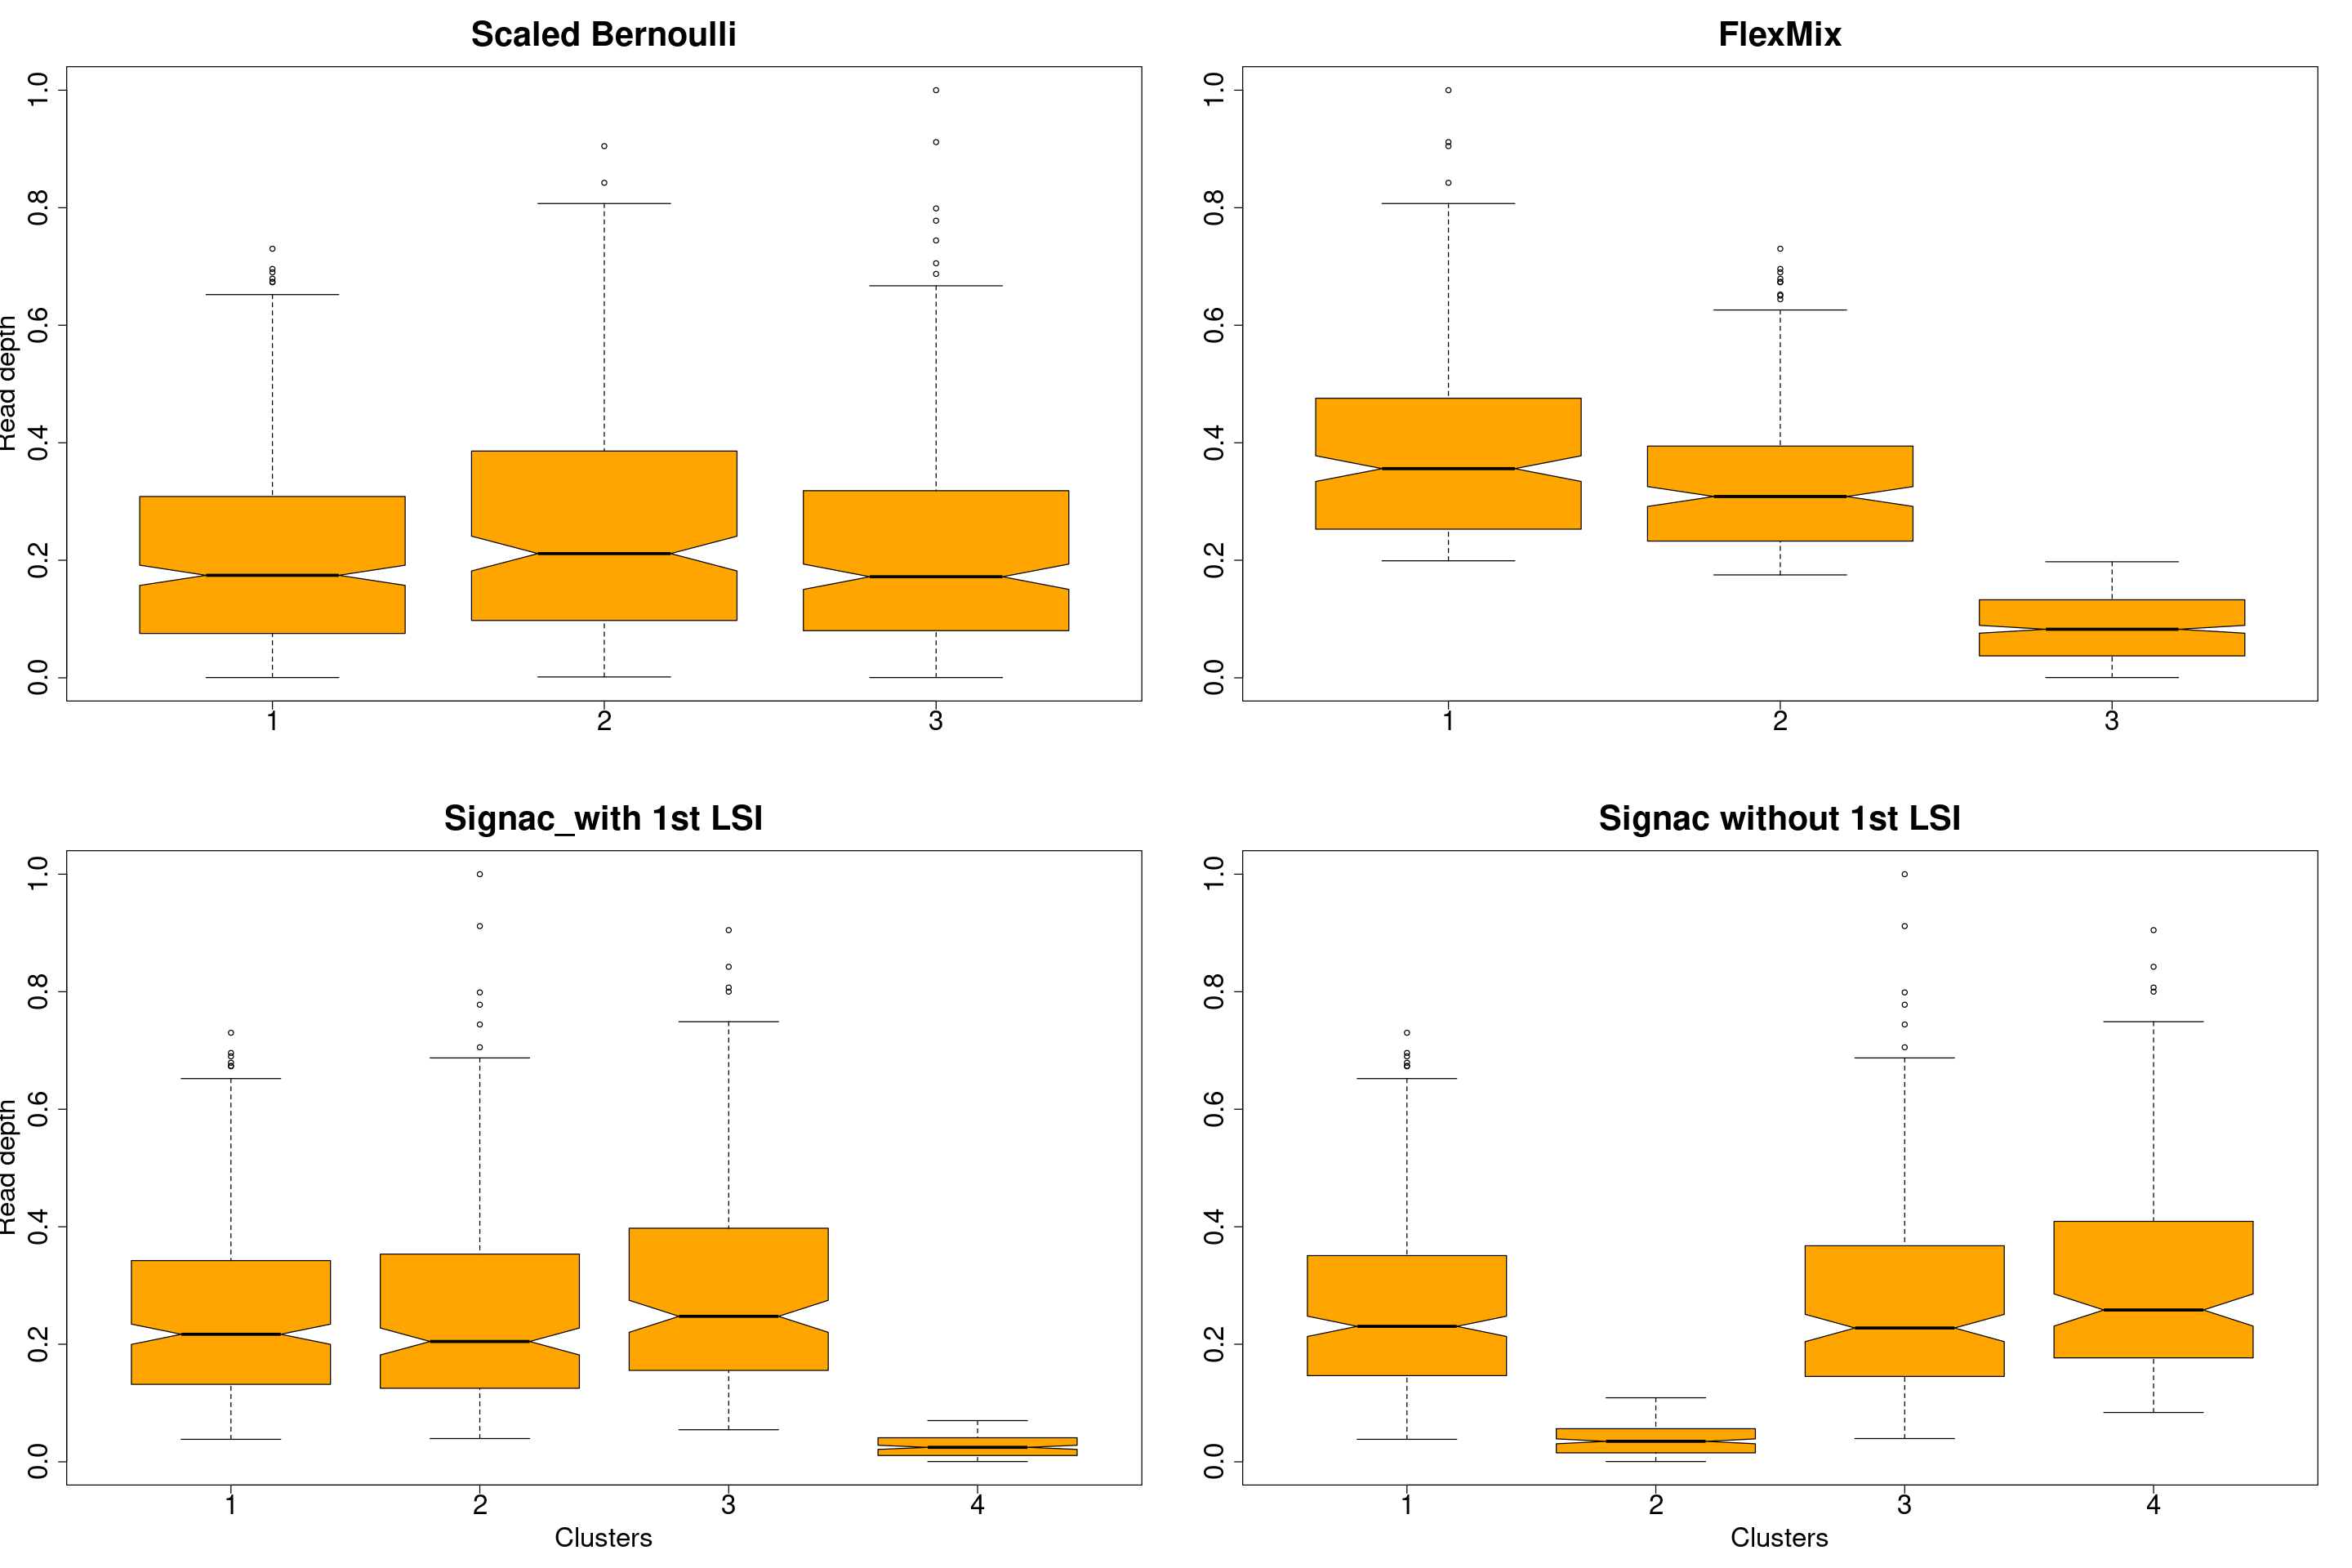

In [91]:
#par(mfrow=c(2,2) + 0.5)

layout(matrix(c(1,2,3,4), 2, 2, byrow = TRUE))

#barplot(t(dp_clusters_SB),
boxplot(t(dp_clusters_SB),
main = "Scaled Bernoulli",
#xlab = "Clusters",
ylab = "Read depth",
names.arg = 1:dim(dp_clusters_SB)[1],
col = "orange",
cex.axis = 2, cex.lab=2,cex.main=2.5,
notch = TRUE,
)

boxplot(t(dp_clusters_FlexMix),
main = "FlexMix",
#xlab = "Clusters",
#ylab = "Read depth",
names.arg = 1:(dim(dp_clusters_FlexMix)[1]),
col = "orange",
cex.axis = 2, cex.lab=2,cex.main=2.5,
notch = TRUE)

boxplot(t(dp_clusters_Seurat_with),
main = "Signac_with 1st LSI",
xlab = "Clusters",
ylab = "Read depth",
names.arg = 0:(dim(dp_clusters_Seurat_with)[1]-1),
col = "orange",
cex.axis = 2, cex.lab=2.0,cex.main=2.5,
notch = TRUE)



boxplot(t(dp_clusters_Seurat_without),
main = "Signac without 1st LSI",
xlab = "Clusters",
#ylab = "Read depth",
names.arg = 0:(dim(dp_clusters_Seurat_without)[1]-1),
col = "orange",
cex.axis = 2, cex.lab=2,cex.main=2.5,
notch = TRUE)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



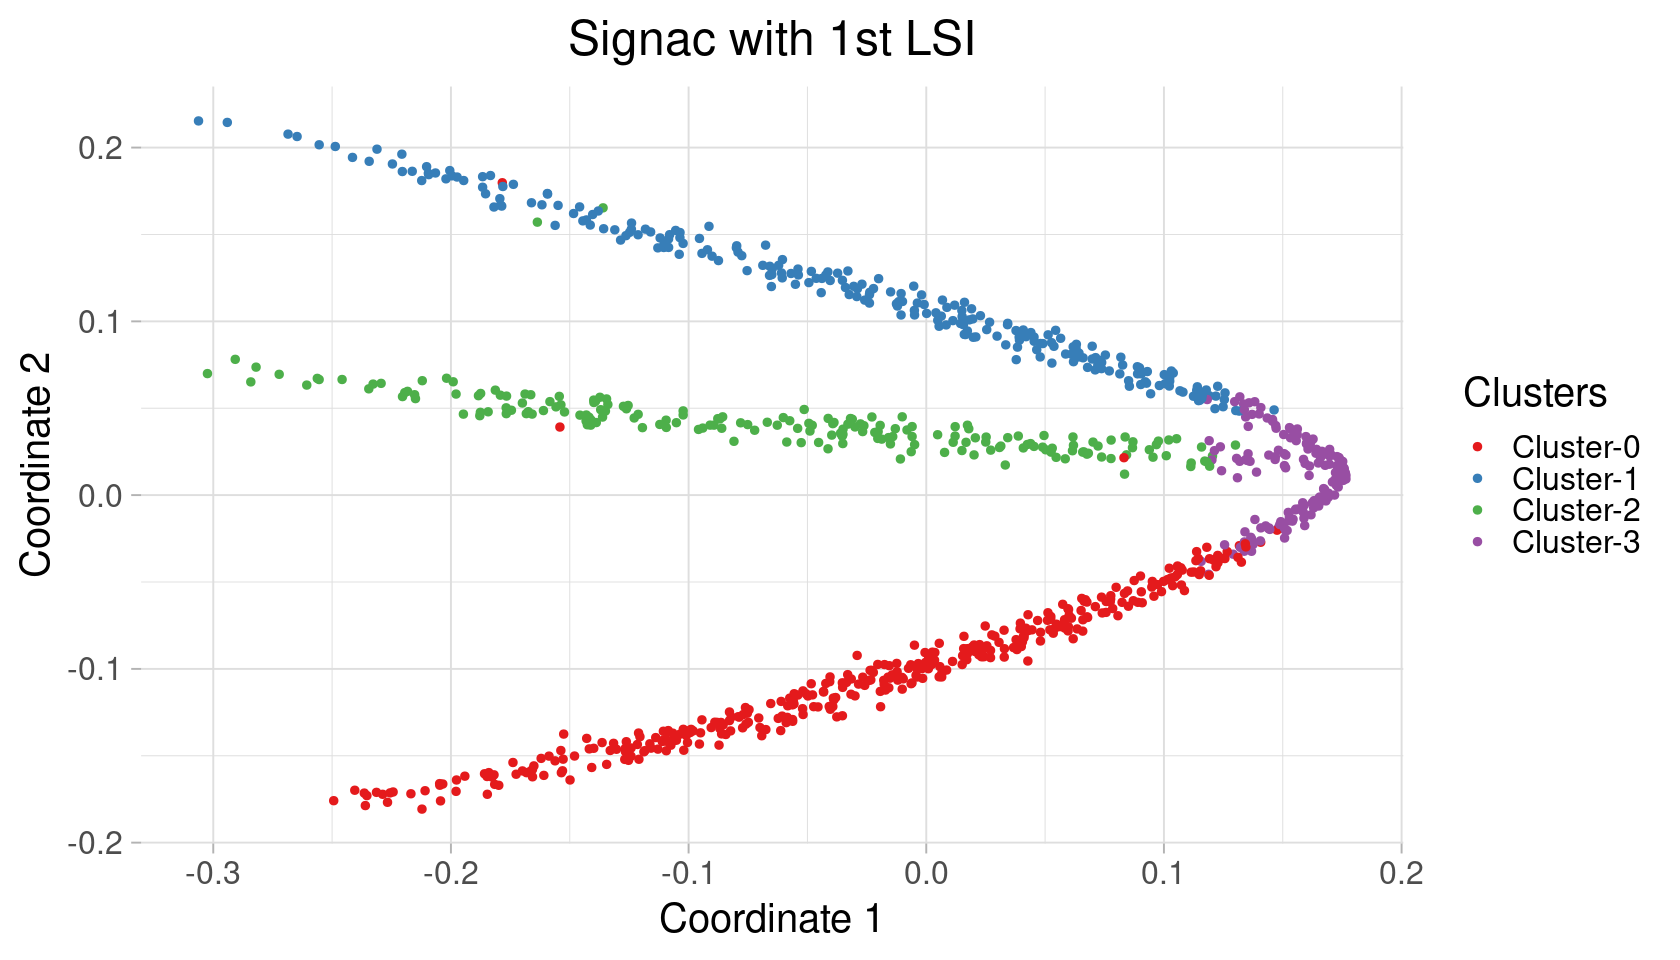

In [185]:
#MDS plot using clusters from Signac with
options(repr.plot.width=14, repr.plot.height=8)
plotMDSClust(t(x), 4, Clusters=paste0('Cluster-',as.character(clusters_Seurat_with)), ret.val=TRUE, text.label=FALSE, title="Signac with 1st LSI")

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



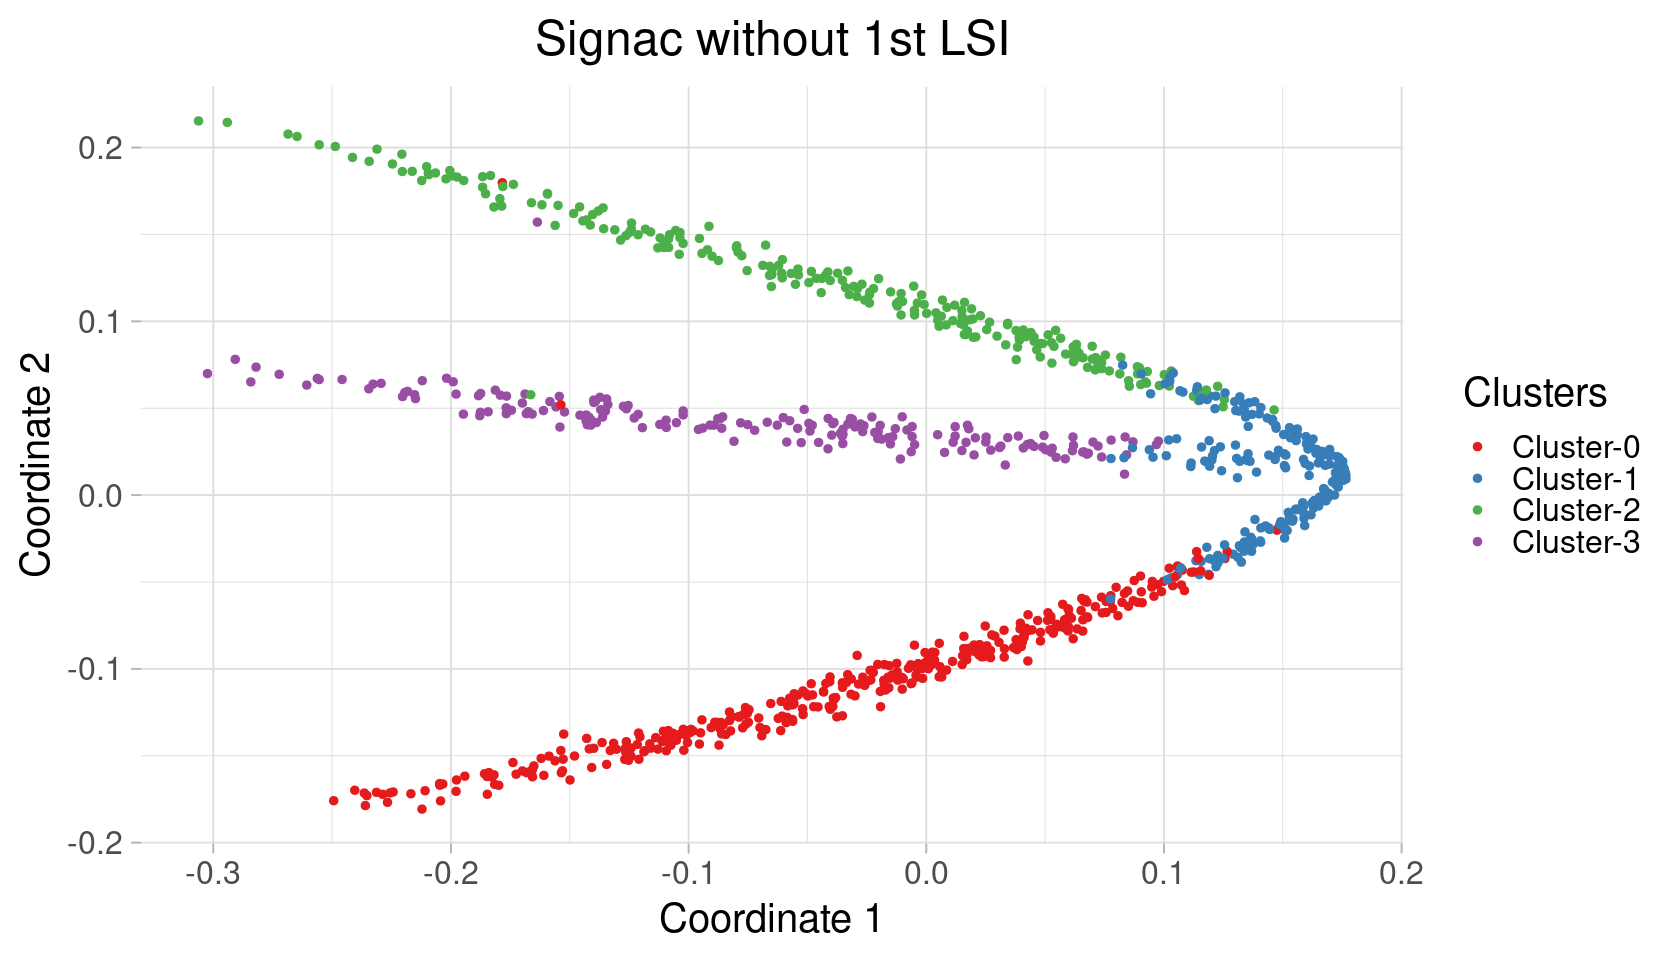

In [186]:
#MDS plot using clusters from Signac without
options(repr.plot.width=14, repr.plot.height=8)
plotMDSClust(t(x), 4, Clusters=paste0('Cluster-',as.character(clusters_Seurat_without)), ret.val=TRUE, text.label=FALSE, title="Signac without 1st LSI")

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



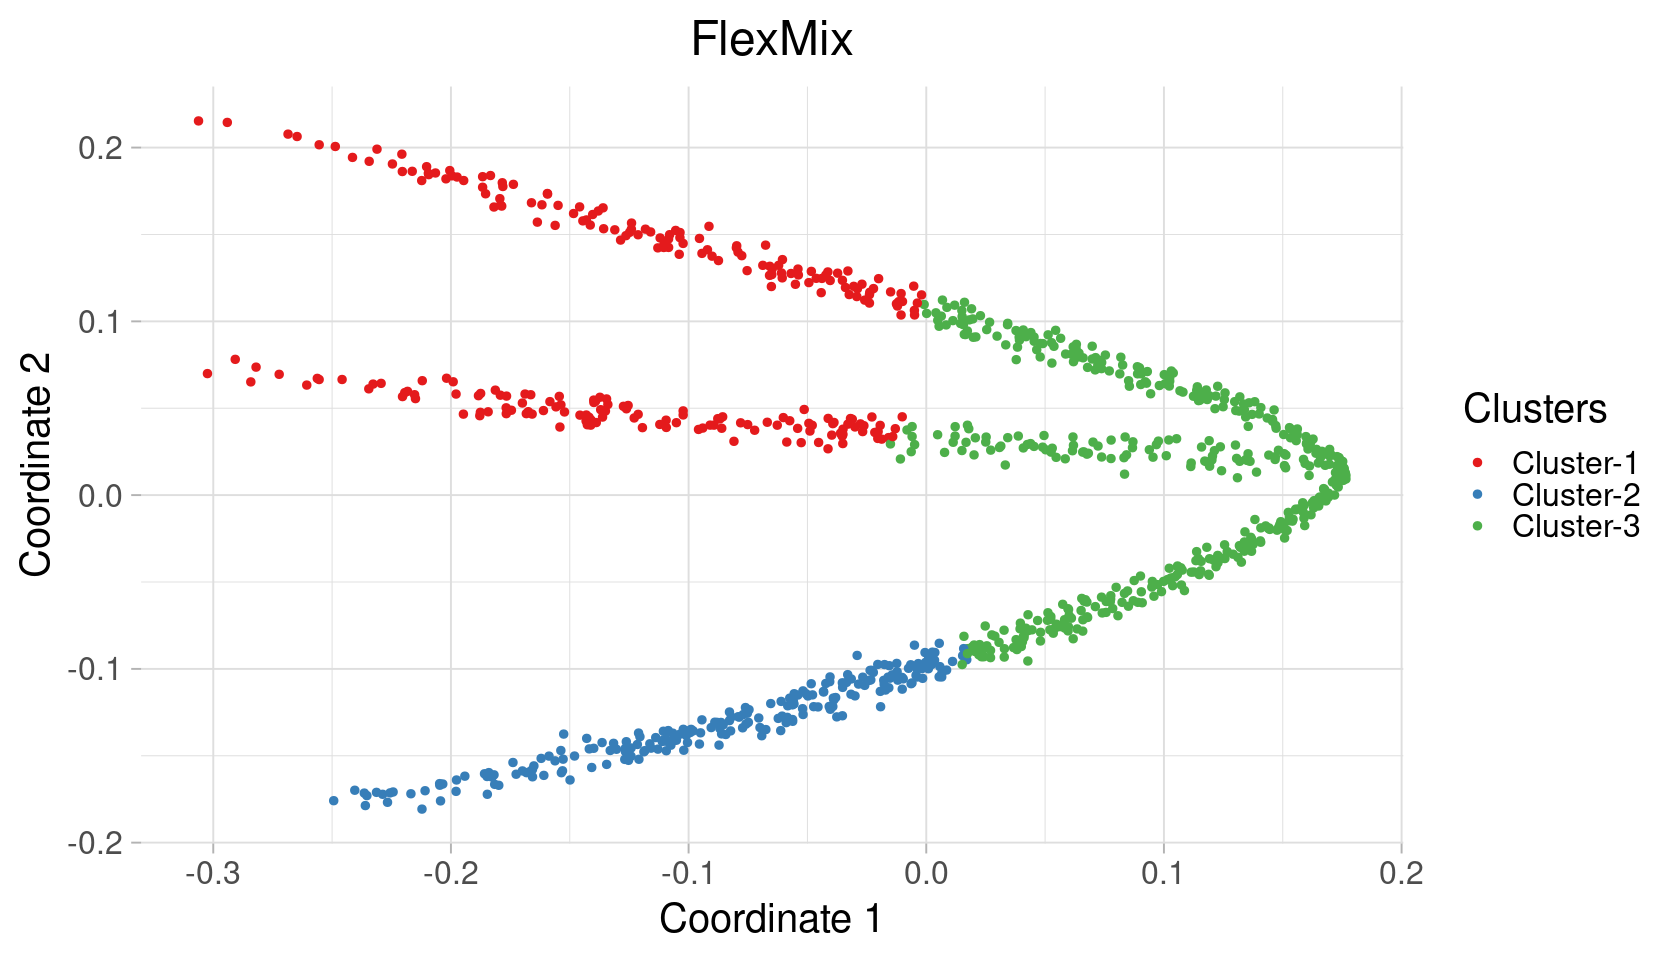

In [187]:
#MDS plot using clusters from FlexMix
options(repr.plot.width=14, repr.plot.height=8)
plotMDSClust(t(x), 4, Clusters=paste0('Cluster-',as.character(clusters_FlexMix)), ret.val=TRUE, text.label=FALSE, title="FlexMix")